# **Evaluate the capacity of Wilson and Cowan firing-rate model to simulate the biological sound processing captured by fMRI data with machine learning - By region and FT2**

This notebook is part of a group project for the Systems Biology masters at Maastricht University.

You can find more details about my capstone project in this [GitHub repository](https://github.com/sayalaruano/Sound_classif_fmri_and_WCfiring_model).

**Dataset description**

This project encompasses two types of data: experimental (fMRI) and modeling (firing activity) datasets. In relation to the experimental dataset, neural responses were measured across brain regions (voxels), in response to 288 auditory stimuli. This data was collected from a cohort of five subjects. The voxels are distributed within the auditory cortex, including core areas (A1 and R) and belt areas (Slow and Fast). The core and belt areas differ in their spectral and temporal information processing.  

The modeling dataset will be obtained using the computational model proposed by  Zulfiqar et al. (2020). This dataset will consist of the firing rates across time and the tonotopic axis of core and belt areas, with each region represented by its own matrix. These matrices will collectively capture the firing activity for the 288 sounds from the experimental dataset.

## **Imports and data obtention**

In [4]:
# Imports
# Data manipulation and EDA
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Machine learning classifers
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

### **Loading modeling datasets**

In [5]:
# Load modeling dataset 
# model_df = pd.read_csv('modeling_fairingrate_dataset_creation/fr_allsounds.csv', header=None)
X_modelA1 = np.genfromtxt('modeling_fairingrate_dataset_creation/FT2_features_obtention/fr_allsoundsA1_FT2.csv', delimiter=',')

X_modelR = np.genfromtxt('modeling_fairingrate_dataset_creation/FT2_features_obtention/fr_allsoundsR_FT2.csv', delimiter=',')

X_modelS = np.genfromtxt('modeling_fairingrate_dataset_creation/FT2_features_obtention/fr_allsoundsS_FT2.csv', delimiter=',')

X_modelF = np.genfromtxt('modeling_fairingrate_dataset_creation/FT2_features_obtention/fr_allsoundsF_FT2.csv', delimiter=',')
model_df_col_names = pd.read_csv('modeling_fairingrate_dataset_creation/fr_labels.csv', header= None)

### **Creating target variable**

In [6]:
# Create the target variable vector for both datasets (modeling and experimental)
# 1-48 = "speech", 49-96 = "voice", 97-144 = "animal", 145-192 = "music", 193-240 = "nature", 241-288 = "tool"
categories = {
    range(1, 49): 'speech',
    range(49, 97): 'voice',
    range(97, 145): 'animal',
    range(145, 193): 'music',
    range(193, 241): 'nature',
    range(241, 289): 'tool'
}

y_labels = [value for i in range(1, 289) for key, value in categories.items() if i in key]

y_labels_df = pd.Series(y_labels)

# Encoding the target class label
y = y_labels_df.map({"speech": 0, "voice": 1, "animal": 2, "music": 3, "nature": 4, "tool": 5}).to_numpy()

### **Training-test split**

In [7]:
# Data splitting on test and training for modeling dataset
X_train_modelA1, X_test_modelA1, y_train_modelA1, y_test_modelA1 = train_test_split(X_modelA1, y, test_size=0.2, random_state =42, stratify=y)

X_train_modelR, X_test_modelR, y_train_modelR, y_test_modelR = train_test_split(X_modelR, y, test_size=0.2, random_state =42, stratify=y)

X_train_modelS, X_test_modelS, y_train_modelS, y_test_modelS = train_test_split(X_modelS, y, test_size=0.2, random_state =42, stratify=y)

X_train_modelF, X_test_modelF, y_train_modelF, y_test_modelF = train_test_split(X_modelF, y, test_size=0.2, random_state =42, stratify=y)

## **Evaluation of the best model on the test dataset**
According to the summary table presented above, the best classfier for the modeling dataset was random forest classfier and for the experimental dataset the support vector machine. Considering that random forest was the second best classifier for the experimental dataset and that we want to compare the performance of the best classifier for each dataset, we will use this algorithm to evaluate the performance on the test dataset for both datasets. We will evaluate the random forest with the best hyperparameters obtained in the cross-validation process of the previous section.

The best hyperparameters for the random forest classifier for the modeling dataset were:
- n_estimators: 1000
- max_depth: 30
- max_features: log2

The best hyperparameters for the random forest classifier for the experimental dataset were:
- n_estimators: 2000
- max_depth: 10
- max_features: auto

In [8]:
# Implementation of the best models
best_rf_modelA1 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='log2', random_state=10))
best_rf_modelR = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='log2', random_state=10))
best_rf_modelS = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='log2', random_state=10))
best_rf_modelF = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='log2', random_state=10))

# Fit the best models
best_rf_modelA1.fit(X_train_modelA1, y_train_modelA1)
best_rf_modelR.fit(X_train_modelR, y_train_modelR)
best_rf_modelS.fit(X_train_modelS, y_train_modelS)
best_rf_modelF.fit(X_train_modelF, y_train_modelF)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, max_features='log2',
                                        n_estimators=1000, random_state=10))])

### **Machine learning models**

In [9]:
# Function to calculate performance metrics
def performance_metrics(y, y_pred):
  acc = accuracy_score(y, y_pred)

  bal_acc = balanced_accuracy_score(y, y_pred)

  prec = precision_score(y, y_pred, average = 'weighted')

  recall = recall_score(y, y_pred,  average = 'weighted')

  f1score = f1_score(y, y_pred,  average = 'weighted')

  mcc = matthews_corrcoef(y, y_pred)

  results = [acc, bal_acc, prec, recall, f1score, mcc]

  return results

### **A1**

In [10]:
# Dataset to store performance metrics of test dataset
results_bestmodels_testA1 = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                'Recall', 'F1score', 'MCC'])
# Set indices
results_bestmodels_testA1.set_index(idxs, inplace=True)

In [11]:
# Predicting values with the best model on test dataset
y_test_pred_modelA1 = best_rf_modelA1.predict(X_test_modelA1)

# Calculate performance metrics of the modeling dataset
results_bestmodels_testA1["RandomForest_modelingdataset_A1"] = performance_metrics(y_test_modelA1, y_test_pred_modelA1)

In [12]:
# Show the final results
results_bestmodels_testA1

,RandomForest_modelingdataset_A1
Accuracy,0.655172
Balanced accuracy,0.662963
Precision,0.676620
Recall,0.655172
F1score,0.650343
MCC,0.592821


In [13]:
# Export results as a csv
results_bestmodels_testA1.to_csv("Results/Byregion_FT2/A1/Results_best_classifiers_modeling_fmri_A1_FT2_datasets.csv")

#### **Performance metrics for every class**

In [14]:
# List of class names
class_names = ["speech", "voice", "animal", "music", "nature", "tool"]

# Performance metrics per class of the best model on the modeling dataset
report_per_class_rf_modelA1 = classification_report(y_true=y_test_modelA1, y_pred=y_test_pred_modelA1,
                                                  target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_model_dfA1 = pd.DataFrame(report_per_class_rf_modelA1).transpose()

# Show the results
report_per_class_rf_model_dfA1

,precision,recall,f1-score,support
speech,0.900000,1.000000,0.947368,9.000000
voice,0.636364,0.777778,0.700000,9.000000
animal,0.400000,0.600000,0.480000,10.000000
music,0.600000,0.300000,0.400000,10.000000
nature,0.666667,0.600000,0.631579,10.000000
tool,0.875000,0.700000,0.777778,10.000000
accuracy,0.655172,0.655172,0.655172,0.655172
macro avg,0.679672,0.662963,0.656121,58.000000
weighted avg,0.676620,0.655172,0.650343,58.000000


In [15]:
# Export results as a csv
report_per_class_rf_model_dfA1.to_csv("Results/Byregion_FT2/A1/Performance_perclass_rf_modeldataset_A1_FT2.csv")

#### **Confusion matrices**

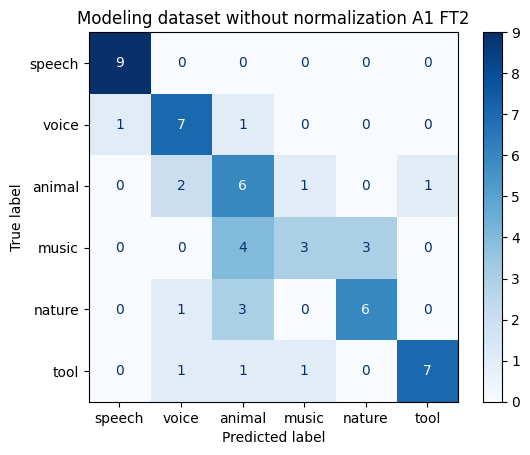

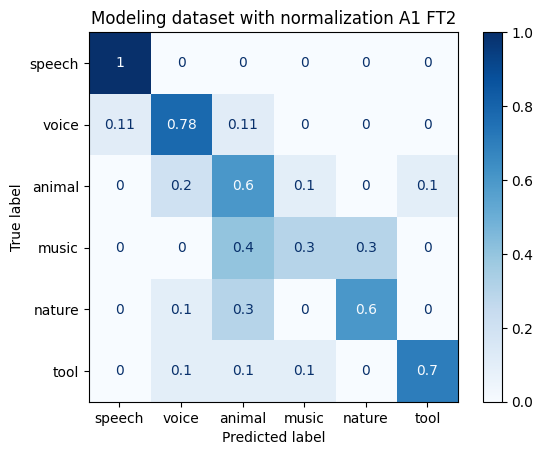

In [16]:
# Create a plot for the confusion matrix of the modeling dataset
titles_options_model = [
    ("Modeling dataset without normalization A1 FT2", None),
    ("Modeling dataset with normalization A1 FT2", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_modelA1, X_test_modelA1, y_test_modelA1,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Byregion_FT2/A1/Confusion_matrix_{title.replace(" ", "_")}.png')

#### **ROC curves**

In [17]:
# Calculate the y_score for the modeling and fMRI datasets
y_score_modelA1 = best_rf_modelA1.predict_proba(X_test_modelA1)

# Binarize the outputs
y_test_bin_modelA1 = label_binarize(y_test_modelA1, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin_modelA1.shape[1]

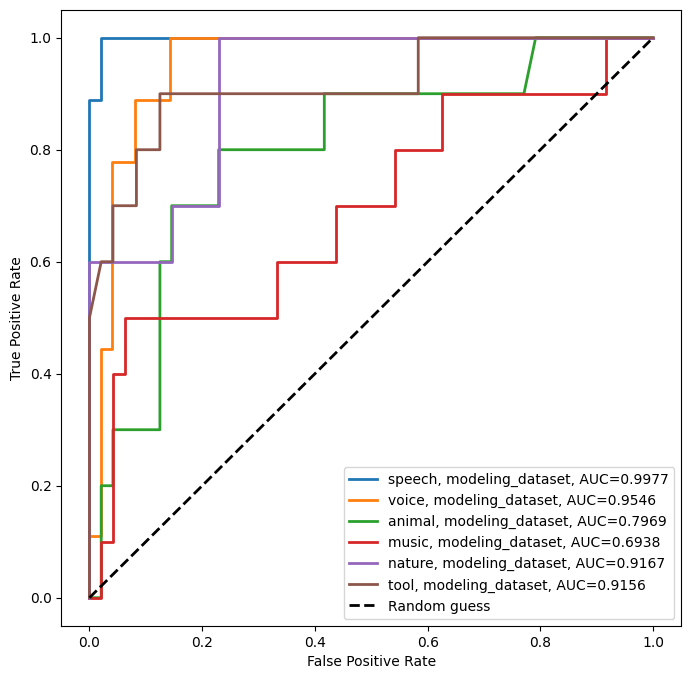

In [18]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_modelA1[:, i], y_score_modelA1[:, i])
  auc = round(roc_auc_score(y_test_bin_modelA1[:, i], y_score_modelA1[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", modeling_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/Byregion_FT2/A1/ROC_curve_bestmodel_modelingdataset_A1_FT2.png', bbox_inches='tight')

### **R**

In [19]:
# Dataset to store performance metrics of test dataset
results_bestmodels_testR = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                'Recall', 'F1score', 'MCC'])
# Set indices
results_bestmodels_testR.set_index(idxs, inplace=True)

In [20]:
# Predicting values with the best model on test dataset
y_test_pred_modelR = best_rf_modelR.predict(X_test_modelR)

# Calculate performance metrics of the modeling dataset
results_bestmodels_testR["RandomForest_modelingdataset_R"] = performance_metrics(y_test_modelR, y_test_pred_modelR)

In [21]:
# Show the final results
results_bestmodels_testR

,RandomForest_modelingdataset_R
Accuracy,0.672414
Balanced accuracy,0.677778
Precision,0.665337
Recall,0.672414
F1score,0.662986
MCC,0.609603


In [22]:
# Export results as a csv
results_bestmodels_testR.to_csv("Results/Byregion_FT2/R/Results_best_classifiers_modeling_fmri_R_FT2_datasets.csv")

#### **Performance metrics for every class**

In [23]:
# List of class names
class_names = ["speech", "voice", "animal", "music", "nature", "tool"]

# Performance metrics per class of the best model on the modeling dataset
report_per_class_rf_modelR = classification_report(y_true=y_test_modelR, y_pred=y_test_pred_modelR,
                                                  target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_model_dfR = pd.DataFrame(report_per_class_rf_modelR).transpose()

# Show the results
report_per_class_rf_model_dfR

,precision,recall,f1-score,support
speech,0.818182,1.000000,0.900000,9.000000
voice,0.666667,0.666667,0.666667,9.000000
animal,0.538462,0.700000,0.608696,10.000000
music,0.428571,0.300000,0.352941,10.000000
nature,0.777778,0.700000,0.736842,10.000000
tool,0.777778,0.700000,0.736842,10.000000
accuracy,0.672414,0.672414,0.672414,0.672414
macro avg,0.667906,0.677778,0.666998,58.000000
weighted avg,0.665337,0.672414,0.662986,58.000000


In [24]:
# Export results as a csv
report_per_class_rf_model_dfR.to_csv("Results/Byregion_FT2/R/Performance_perclass_rf_modeldataset_R_FT2.csv")

#### **Confusion matrices**

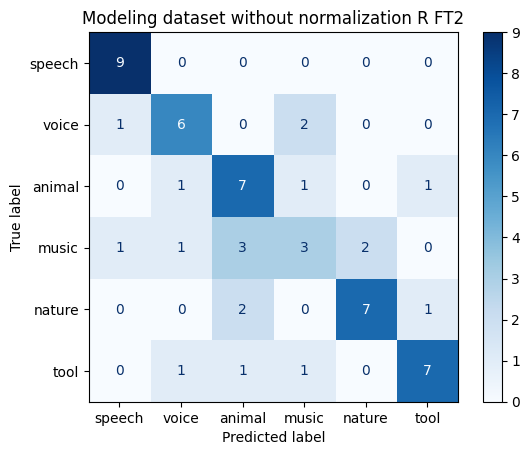

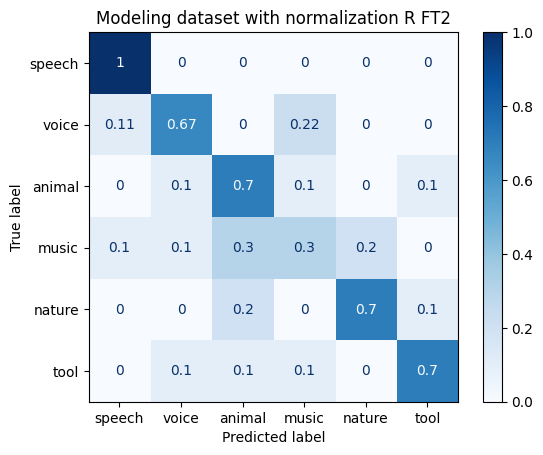

In [25]:
# Create a plot for the confusion matrix of the modeling dataset
titles_options_model = [
    ("Modeling dataset without normalization R FT2", None),
    ("Modeling dataset with normalization R FT2", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_modelR, X_test_modelR, y_test_modelR,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Byregion_FT2/R/Confusion_matrix_{title.replace(" ", "_")}.png')

#### **ROC curves**

In [26]:
# Calculate the y_score for the modeling and fMRI datasets
y_score_modelR = best_rf_modelR.predict_proba(X_test_modelR)

# Binarize the outputs
y_test_bin_modelR = label_binarize(y_test_modelR, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin_modelR.shape[1]

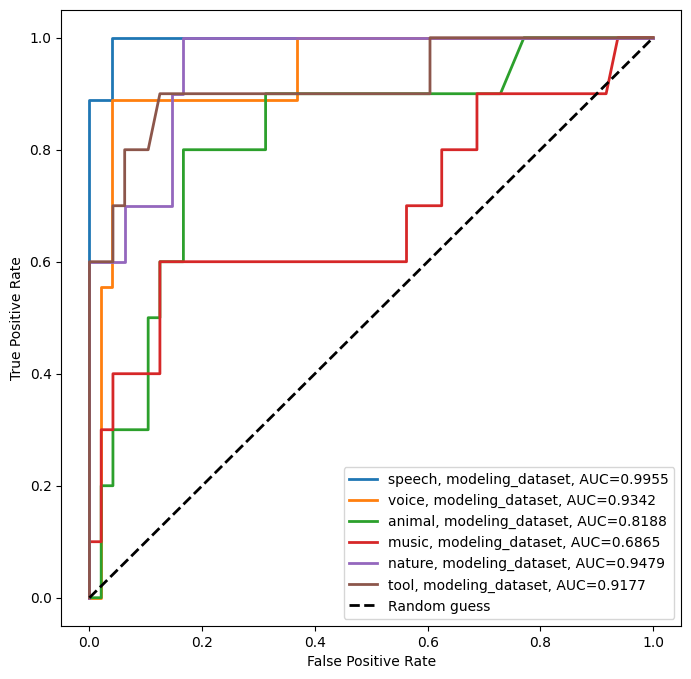

In [27]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_modelR[:, i], y_score_modelR[:, i])
  auc = round(roc_auc_score(y_test_bin_modelR[:, i], y_score_modelR[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", modeling_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/Byregion_FT2/R/ROC_curve_bestmodel_modelingdataset_R_FT2.png', bbox_inches='tight')

### **S**

In [28]:
# Dataset to store performance metrics of test dataset
results_bestmodels_testS = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                'Recall', 'F1score', 'MCC'])
# Set indices
results_bestmodels_testS.set_index(idxs, inplace=True)

In [29]:
# Predicting values with the best model on test dataset
y_test_pred_modelS = best_rf_modelS.predict(X_test_modelS)

# Calculate performance metrics of the modeling dataset
results_bestmodels_testS["RandomForest_modelingdataset_S"] = performance_metrics(y_test_modelS, y_test_pred_modelS)

In [30]:
# Show the final results
results_bestmodels_testS

,RandomForest_modelingdataset_S
Accuracy,0.568966
Balanced accuracy,0.574074
Precision,0.571855
Recall,0.568966
F1score,0.556980
MCC,0.489024


In [31]:
# Export results as a csv
results_bestmodels_testS.to_csv("Results/Byregion_FT2/S/Results_best_classifiers_modeling_fmri_S_FT2_datasets.csv")

#### **Performance metrics for every class**

In [32]:
# List of class names
class_names = ["speech", "voice", "animal", "music", "nature", "tool"]

# Performance metrics per class of the best model on the modeling dataset
report_per_class_rf_modelS = classification_report(y_true=y_test_modelS, y_pred=y_test_pred_modelS,
                                                  target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_model_dfS = pd.DataFrame(report_per_class_rf_modelS).transpose()

# Show the results
report_per_class_rf_model_dfS

,precision,recall,f1-score,support
speech,0.750000,0.666667,0.705882,9.000000
voice,0.538462,0.777778,0.636364,9.000000
animal,0.466667,0.700000,0.560000,10.000000
music,0.166667,0.100000,0.125000,10.000000
nature,0.666667,0.600000,0.631579,10.000000
tool,0.857143,0.600000,0.705882,10.000000
accuracy,0.568966,0.568966,0.568966,0.568966
macro avg,0.574267,0.574074,0.560785,58.000000
weighted avg,0.571855,0.568966,0.556980,58.000000


In [33]:
# Export results as a csv
report_per_class_rf_model_dfS.to_csv("Results/Byregion_FT2/S/Performance_perclass_rf_modeldataset_S_FT2.csv")

#### **Confusion matrices**

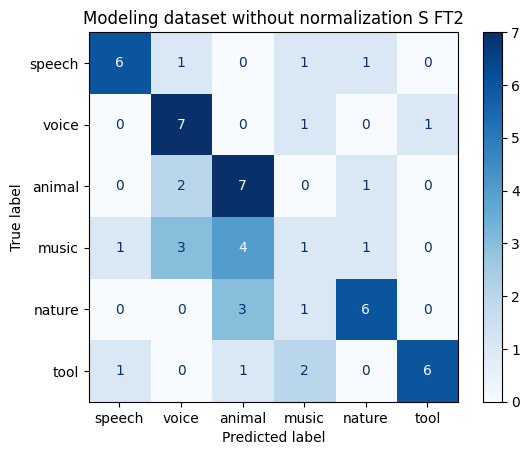

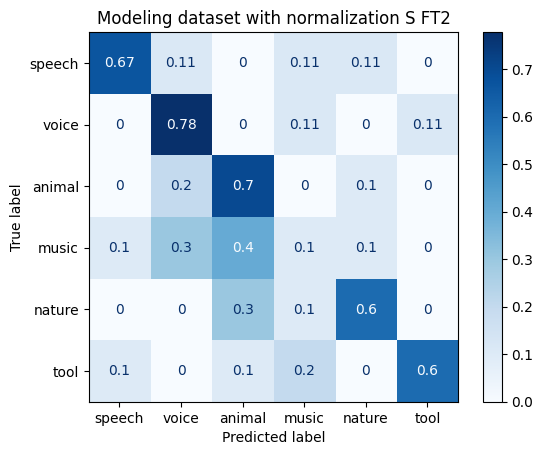

In [34]:
# Create a plot for the confusion matrix of the modeling dataset
titles_options_model = [
    ("Modeling dataset without normalization S FT2", None),
    ("Modeling dataset with normalization S FT2", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_modelS, X_test_modelS, y_test_modelS,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Byregion_FT2/S/Confusion_matrix_{title.replace(" ", "_")}.png')

#### **ROC curves**

In [35]:
# Calculate the y_score for the modeling and fMRI datasets
y_score_modelS = best_rf_modelS.predict_proba(X_test_modelS)

# Binarize the outputs
y_test_bin_modelS = label_binarize(y_test_modelS, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin_modelS.shape[1]

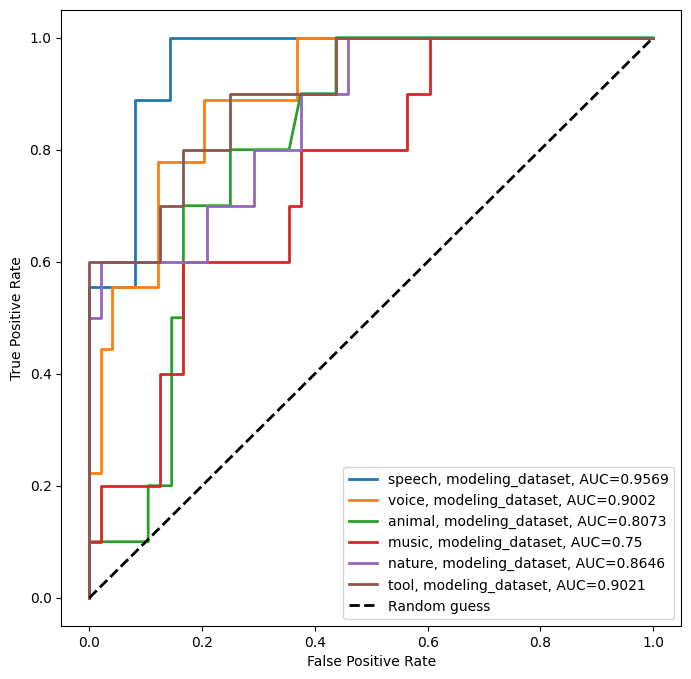

In [36]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_modelS[:, i], y_score_modelS[:, i])
  auc = round(roc_auc_score(y_test_bin_modelS[:, i], y_score_modelS[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", modeling_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/Byregion_FT2/S/ROC_curve_bestmodel_modelingdataset_S_FT2.png', bbox_inches='tight')

### **F**

In [37]:
# Dataset to store performance metrics of test dataset
results_bestmodels_testF = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                'Recall', 'F1score', 'MCC'])
# Set indices
results_bestmodels_testF.set_index(idxs, inplace=True)

In [38]:
# Predicting values with the best model on test dataset
y_test_pred_modelF = best_rf_modelF.predict(X_test_modelF)

# Calculate performance metrics of the modeling dataset
results_bestmodels_testF["RandomForest_modelingdataset_F"] = performance_metrics(y_test_modelF, y_test_pred_modelF)

In [39]:
# Show the final results
results_bestmodels_testF

,RandomForest_modelingdataset_F
Accuracy,0.568966
Balanced accuracy,0.574074
Precision,0.575758
Recall,0.568966
F1score,0.563748
MCC,0.486353


In [40]:
# Export results as a csv
results_bestmodels_testF.to_csv("Results/Byregion_FT2/F/Results_best_classifiers_modeling_fmri_F_FT2_datasets.csv")

#### **Performance metrics for every class**

In [41]:
# List of class names
class_names = ["speech", "voice", "animal", "music", "nature", "tool"]

# Performance metrics per class of the best model on the modeling dataset
report_per_class_rf_modelF = classification_report(y_true=y_test_modelF, y_pred=y_test_pred_modelF,
                                                  target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_model_dfF = pd.DataFrame(report_per_class_rf_modelF).transpose()

# Show the results
report_per_class_rf_model_dfF

,precision,recall,f1-score,support
speech,0.750000,0.666667,0.705882,9.000000
voice,0.636364,0.777778,0.700000,9.000000
animal,0.466667,0.700000,0.560000,10.000000
music,0.375000,0.300000,0.333333,10.000000
nature,0.500000,0.400000,0.444444,10.000000
tool,0.750000,0.600000,0.666667,10.000000
accuracy,0.568966,0.568966,0.568966,0.568966
macro avg,0.579672,0.574074,0.568388,58.000000
weighted avg,0.575758,0.568966,0.563748,58.000000


In [42]:
# Export results as a csv
report_per_class_rf_model_dfF.to_csv("Results/Byregion_FT2/F/Performance_perclass_rf_modeldataset_F_FT2.csv")

#### **Confusion matrices**

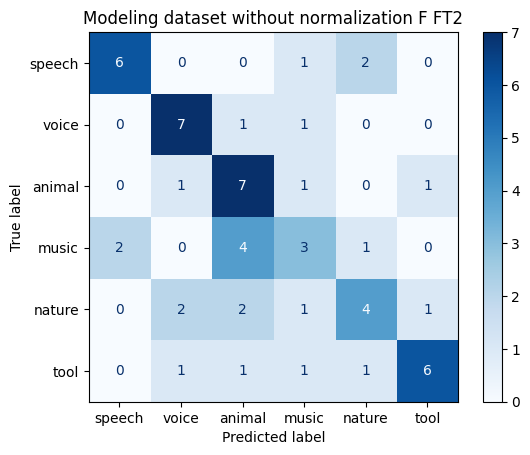

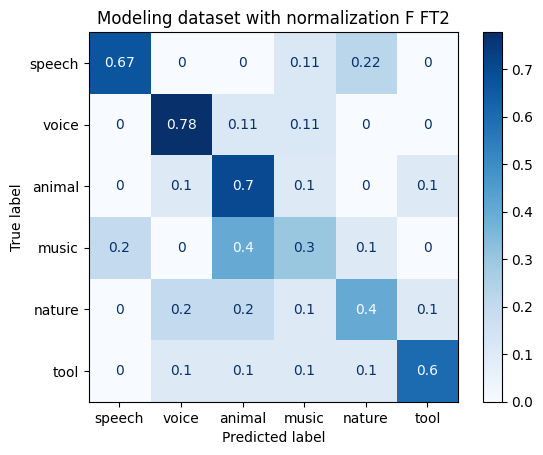

In [43]:
# Create a plot for the confusion matrix of the modeling dataset
titles_options_model = [
    ("Modeling dataset without normalization F FT2", None),
    ("Modeling dataset with normalization F FT2", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_modelF, X_test_modelF, y_test_modelF,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Byregion_FT2/F/Confusion_matrix_{title.replace(" ", "_")}.png')

#### **ROC curves**

In [44]:
# Calculate the y_score for the modeling and fMRI datasets
y_score_modelF = best_rf_modelF.predict_proba(X_test_modelF)

# Binarize the outputs
y_test_bin_modelF = label_binarize(y_test_modelF, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin_modelF.shape[1]

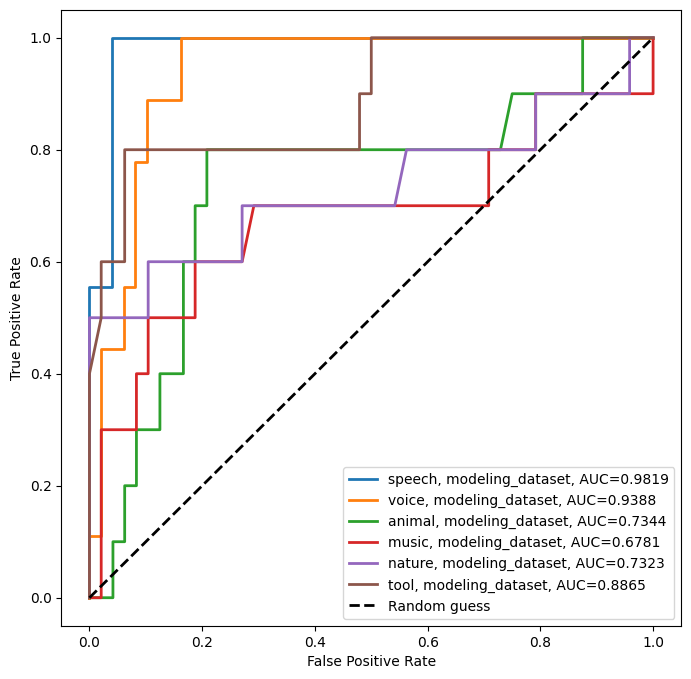

In [45]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_modelF[:, i], y_score_modelF[:, i])
  auc = round(roc_auc_score(y_test_bin_modelF[:, i], y_score_modelF[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", modeling_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/Byregion_FT2/F/ROC_curve_bestmodel_modelingdataset_F_FT2.png', bbox_inches='tight')